# Adaptive Dynamic Pricing Based on Customer Sensitivity (Real-World Dataset)

## 1. Introduction
This project uses real Amazon purchase and demographic data to simulate an e-commerce pricing scenario. We model adaptive pricing strategies (epsilon-greedy, UCB, and Thompson Sampling) for multiple customer segments, based on real demographic information and purchase behavior.


# 🟢 Step 1: Import Libraries and Setup

In [92]:
# 🧪 Imports & Setup
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', 100)
sns.set(style="whitegrid")


# 🟢 Step 2: Load and Preview the Dataset

In [95]:
# Load survey dataset (for segmentation)
survey_df = pd.read_csv("survey.csv")

# Clean column names for easier handling
survey_df.columns = [col.strip() for col in survey_df.columns]

# Display sample
survey_df.head()


,Survey ResponseID,Q-demos-age,Q-demos-hispanic,Q-demos-race,Q-demos-education,Q-demos-income,Q-demos-gender,Q-sexual-orientation,Q-demos-state,Q-amazon-use-howmany,Q-amazon-use-hh-size,Q-amazon-use-how-oft,Q-substance-use-cigarettes,Q-substance-use-marijuana,Q-substance-use-alcohol,Q-personal-diabetes,Q-personal-wheelchair,Q-life-changes,Q-sell-YOUR-data,Q-sell-consumer-data,Q-small-biz-use,Q-census-use,Q-research-society
0,R_1ou69fj4DQGsVcp,35 - 44 years,No,Black or African American,High school diploma or GED,"$25,000 - $49,999",Female,heterosexual (straight),Iowa,2,2,Less than 5 times per month,Yes,No,Yes,No,No,Lost a job,No,No,No,No,No
1,R_2UbJL30HRjK1sdD,45 - 54 years,No,White or Caucasian,High school diploma or GED,"$100,000 - $149,999",Male,heterosexual (straight),Ohio,2,4+,Less than 5 times per month,No,No,No,No,No,NaN,No,No,No,No,Yes
2,R_UPXamGKtmf4RVIZ,25 - 34 years,No,White or Caucasian,High school diploma or GED,"$25,000 - $49,999",Male,heterosexual (straight),Arkansas,1 (just me!),2,Less than 5 times per month,No,No,No,Yes,No,NaN,No,No,No,No,Yes
3,R_2dYk5auG9Fv5Qve,35 - 44 years,Yes,White or Caucasian,"Graduate or professional degree (MA, MS, MBA, ...","$50,000 - $74,999",Male,heterosexual (straight),Tennessee,1 (just me!),1 (just me!),Less than 5 times per month,No,No,No,No,No,NaN,No,No,No,No,No
4,R_2aP0GyIR66gSTiR,25 - 34 years,No,White or Caucasian,High school diploma or GED,"$50,000 - $74,999",Male,heterosexual (straight),Virginia,2,3,Less than 5 times per month,No,No,Yes,No,No,NaN,No,Yes if consumers get part of the profit,I don't know,No,No


# 🟢 Step 3: Create Manual Segments Based on Age and Income

In [98]:
# Segment customers based on age and income
def classify_segment(row):
    income = row['Q-demos-income']
    age = row['Q-demos-age']

    if pd.isnull(income) or pd.isnull(age):
        return 'unknown'

    if income in ['Under $25,000', '$25,000 - $49,999']:
        return 'elastic'
    elif income in ['$50,000 - $74,999', '$75,000 - $99,999']:
        return 'moderate'
    else:
        return 'inelastic'

survey_df['segment'] = survey_df.apply(classify_segment, axis=1)
survey_df['segment'].value_counts()


segment
inelastic    2014
moderate     1824
elastic      1189
Name: count, dtype: int64

# 🟢 Step 4: Set Price Points and Conversion Probabilities

In [101]:
# Use real price points extracted from the Amazon purchases data
price_points = [7.99, 9.99, 12.99, 19.99, 24.99]


In [103]:
# Simulate conversion probabilities per segment
conversion_probs = {
    'elastic':    [0.9, 0.8, 0.5, 0.2, 0.1],
    'moderate':   [0.6, 0.7, 0.6, 0.4, 0.3],
    'inelastic':  [0.3, 0.5, 0.6, 0.7, 0.6]
}


# 🟢 Step 5: Simulate Epsilon-Greedy Algorithm with Non-Stationary Demand

In [106]:
n_customers = 1000
epsilon = 0.1

# Non-stationary demand segment seçimi
def get_segment(t):
    if t < n_customers // 2:
        probs = [0.5, 0.3, 0.2]
    else:
        probs = [0.2, 0.4, 0.4]
    return np.random.choice(['elastic', 'moderate', 'inelastic'], p=probs)


counts_eg = np.zeros(len(price_points))
rewards_eg = np.zeros(len(price_points))
revenue_eg = []

for t in range(n_customers):
    segment = get_segment(t)

    if np.random.rand() < epsilon:
        price_idx = np.random.choice(len(price_points))
    else:
        avg_reward = rewards_eg / (counts_eg + 1e-5)
        price_idx = np.argmax(avg_reward)

    price = price_points[price_idx]
    prob = conversion_probs[segment][price_idx]
    purchase = np.random.rand() < prob

    if purchase:
        rewards_eg[price_idx] += price
        revenue_eg.append(price)
    else:
        revenue_eg.append(0)

    counts_eg[price_idx] += 1


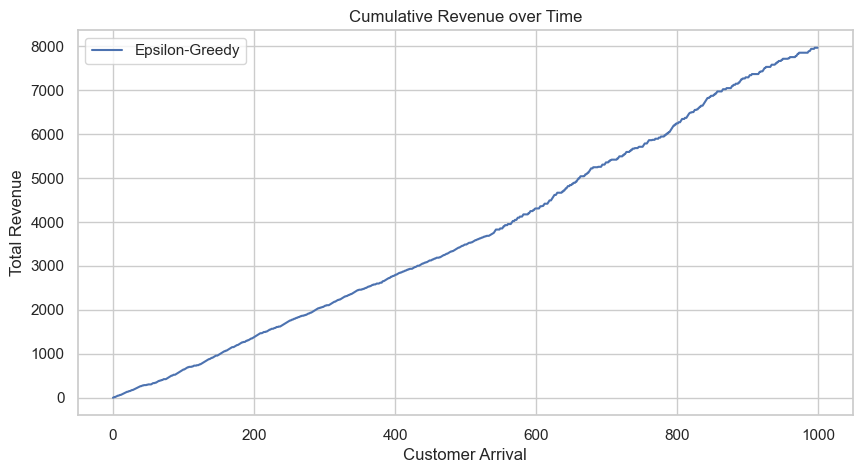

In [108]:
# Cumulative Revenue Plot
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(revenue_eg), label='Epsilon-Greedy')
plt.title("Cumulative Revenue over Time")
plt.xlabel("Customer Arrival")
plt.ylabel("Total Revenue")
plt.grid(True)
plt.legend()
plt.show()


# 🟢 Step 6: Simulate UCB Algorithm

In [111]:
counts_ucb = np.zeros(len(price_points))
rewards_ucb = np.zeros(len(price_points))
revenue_ucb = []

for t in range(1, n_customers + 1):
    segment = get_segment(t)


    if t <= len(price_points):
        price_idx = t - 1  # Try each price once
    else:
        avg_reward_ucb = rewards_ucb / (counts_ucb + 1e-5)
        confidence_bounds = np.sqrt(2 * np.log(t) / (counts_ucb + 1e-5))
        ucb_scores = avg_reward_ucb + confidence_bounds
        price_idx = np.argmax(ucb_scores)

    price = price_points[price_idx]
    prob = conversion_probs[segment][price_idx]
    purchase = np.random.rand() < prob

    if purchase:
        rewards_ucb[price_idx] += price
        revenue_ucb.append(price)
    else:
        revenue_ucb.append(0)

    counts_ucb[price_idx] += 1


# 🟢 Step 7: Simulate Thompson Sampling Algorithm

In [114]:
# --- Thompson Sampling Algorithm ---
alpha_ts = np.ones(len(price_points))
beta_ts = np.ones(len(price_points))
revenue_ts = []

for t in range(n_customers):
    segment = get_segment(t)  # use same segment generator

    sampled_theta = np.random.beta(alpha_ts, beta_ts)
    expected_reward = sampled_theta * price_points
    price_idx = np.argmax(expected_reward)

    price = price_points[price_idx]
    prob = conversion_probs[segment][price_idx]
    purchase = np.random.rand() < prob

    if purchase:
        alpha_ts[price_idx] += 1
        revenue_ts.append(price)
    else:
        beta_ts[price_idx] += 1
        revenue_ts.append(0)



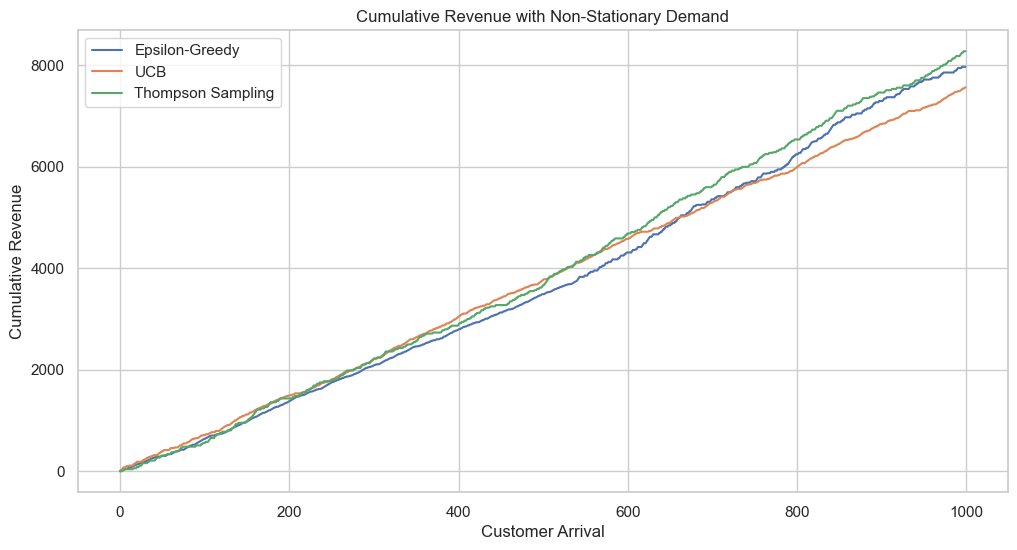

In [116]:
# 📊 Final Comparison Plot
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(revenue_eg), label='Epsilon-Greedy')
plt.plot(np.cumsum(revenue_ucb), label='UCB')
plt.plot(np.cumsum(revenue_ts), label='Thompson Sampling')
plt.title("Cumulative Revenue with Non-Stationary Demand")
plt.xlabel("Customer Arrival")
plt.ylabel("Cumulative Revenue")
plt.legend()
plt.grid(True)
plt.show()


# 🟢 Step 8: Oracle Benchmark and Regret Calculation

In [119]:

oracle_revenue = []


for price_idx, price in enumerate(price_points):
    revenue = 0
    for t in range(n_customers):
        segment = get_segment(t)
        prob = conversion_probs[segment][price_idx]
        expected_purchase = prob * price
        revenue += expected_purchase
    oracle_revenue.append(revenue)


best_price_idx = np.argmax(oracle_revenue)
best_price = price_points[best_price_idx]


In [121]:
# Oracle cumulative revenue
oracle_cumrev = []
total = 0

for t in range(n_customers):
    segment = get_segment(t)
    prob = conversion_probs[segment][best_price_idx]
    revenue = prob * best_price
    total += revenue
    oracle_cumrev.append(total)


In [123]:
# Cumulative reward already computed as:
# np.cumsum(revenue_eg), np.cumsum(revenue_ucb), np.cumsum(revenue_ts)

regret_eg = np.array(oracle_cumrev) - np.cumsum(revenue_eg)
regret_ucb = np.array(oracle_cumrev) - np.cumsum(revenue_ucb)
regret_ts = np.array(oracle_cumrev) - np.cumsum(revenue_ts)


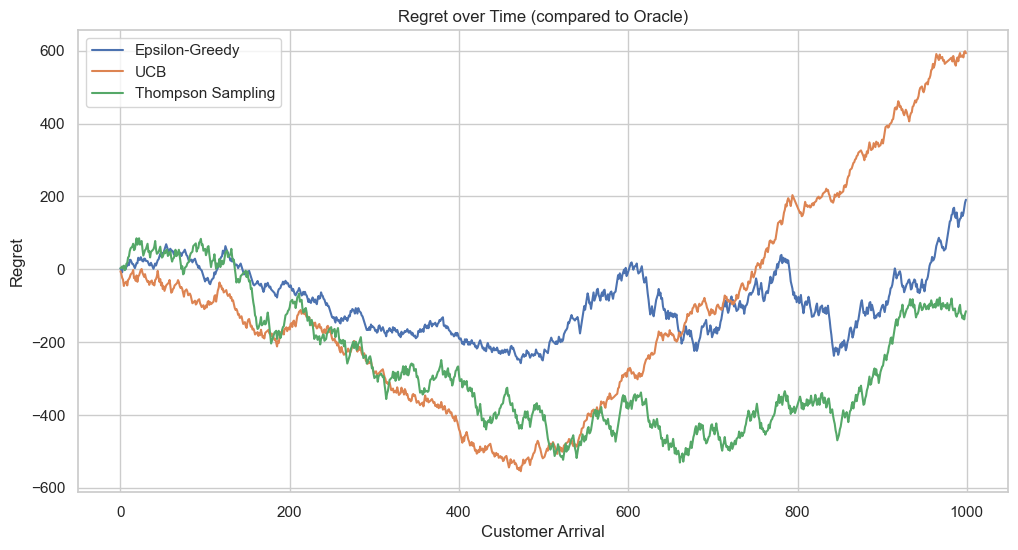

In [125]:
# 📈 Regret Plot
plt.figure(figsize=(12, 6))
plt.plot(regret_eg, label='Epsilon-Greedy')
plt.plot(regret_ucb, label='UCB')
plt.plot(regret_ts, label='Thompson Sampling')
plt.title("Regret over Time (compared to Oracle)")
plt.xlabel("Customer Arrival")
plt.ylabel("Regret")
plt.legend()
plt.grid(True)
plt.show()


# 🟢 Step 9: Prepare Features for Clustering (Encode Categorical Variables to Numbers)

In [128]:

ml_df = survey_df[['Q-demos-age', 'Q-demos-income', 'Q-amazon-use-howmany', 'Q-amazon-use-how-oft']].copy()


ml_df.dropna(inplace=True)

# Yaş kategorilerini sayıya çevir
age_order = {
    '18 - 24 years': 1,
    '25 - 34 years': 2,
    '35 - 44 years': 3,
    '45 - 54 years': 4,
    '55 - 64 years': 5,
    '65 - 74 years': 6,
    '75 years or older': 7
}


income_order = {
    'Under $25,000': 1,
    '$25,000 – $49,999': 2,
    '$50,000 – $74,999': 3,
    '$75,000 – $99,999': 4,
    '$100,000 – $149,999': 5,
    '$150,000 or more': 6
}


usage_map = {
    'Less than 5 times per month': 1,
    '5 to 15 times per month': 2,
    'More than 15 times per month': 3
}


ml_df['age_enc'] = ml_df['Q-demos-age'].map(age_order)
ml_df['income_enc'] = ml_df['Q-demos-income'].map(income_order)
ml_df['use_freq'] = ml_df['Q-amazon-use-how-oft'].map(usage_map)
ml_df['how_many'] = pd.to_numeric(ml_df['Q-amazon-use-howmany'], errors='coerce')


features = ml_df[['age_enc', 'income_enc', 'use_freq', 'how_many']].dropna()


# 🟢 Step 10: Standardize & Cluster Using KMeans

In [131]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)


kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)


features['cluster'] = cluster_labels


# 🟢 Step 11: Visualize final clusters with PCA

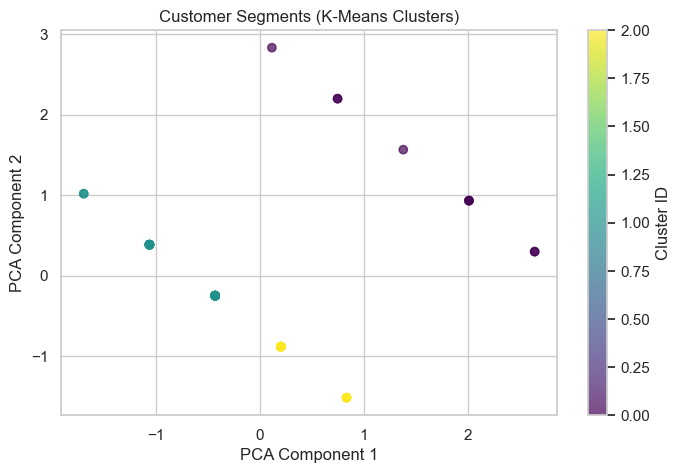

In [134]:

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.title("Customer Segments (K-Means Clusters)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster ID')
plt.grid(True)
plt.show()


# 🟢 Step 12: Check size of each label from earlier rule-based segmentation

In [137]:
survey_df['segment'].value_counts()


segment
inelastic    2014
moderate     1824
elastic      1189
Name: count, dtype: int64

# 🟢 Step 13: Compare dataset size before and after clustering

In [140]:
print(f"Original dataset: {len(survey_df)} rows")
print(f"Used in clustering: {len(features)} rows")

Original dataset: 5027 rows
Used in clustering: 48 rows


# 🟢 Step 14: Full code for PCA- Customer Segments Via Kmeans

Original dataset: 5027 rows
Used in clustering: 209 rows


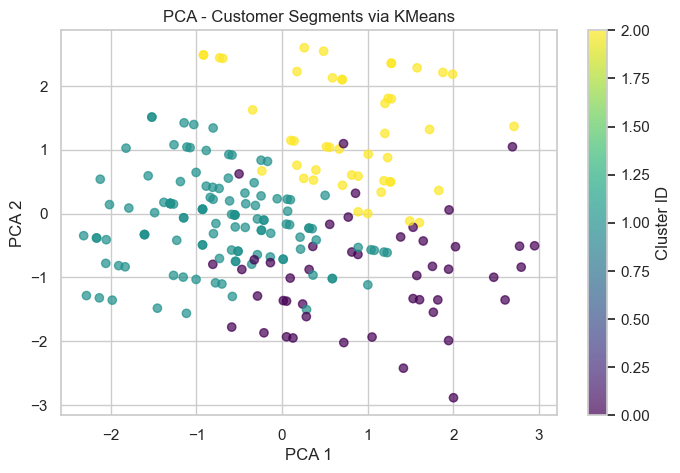


Cluster-level averages (for interpretation):
          age_enc   age_enc  income_enc  income_enc  use_freq  use_freq  \
cluster                                                                   
0.0      1.934783  1.750000         5.0         5.0       0.0       0.0   
1.0      2.170940  1.598214         5.0         5.0       0.0       0.0   
2.0      0.608696  1.590909         5.0         5.0       0.0       0.0   

         how_many  how_many  
cluster                      
0.0      2.195652  0.608696  
1.0      0.000000  0.623932  
2.0      0.086957  0.413043  


In [143]:
# 📌 1. Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
pd.set_option('display.max_columns', 100)

# 📌 2. Load dataset
survey_df = pd.read_csv("survey.csv")
survey_df.columns = [col.strip() for col in survey_df.columns]  # Clean column names

# 📌 3. Encode relevant features
# Age encoding
age_map = {
    '18 - 24 years': 0, '25 - 34 years': 1, '35 - 44 years': 2,
    '45 - 54 years': 3, '55 - 64 years': 4, '65 years or more': 5
}
survey_df['age_enc'] = survey_df['Q-demos-age'].map(age_map)

# Income encoding
income_map = {
    'Under $25,000': 0, '25,000—49,999': 1, '50,000—74,999': 2,
    '75,000—99,999': 3, '100,000—149,999': 4, '$150,000 or more': 5
}
survey_df['income_enc'] = survey_df['Q-demos-income'].map(income_map)

# Usage frequency encoding
use_freq_map = {
    'Less than 5 times per month': 0, '5-9 times per month': 1,
    '10-19 times per month': 2, '20-29 times per month': 3, '30 or more times per month': 4
}
survey_df['use_freq'] = survey_df['Q-amazon-use-how-oft'].map(use_freq_map)

# Amazon use how many (convert to numeric)
survey_df['how_many'] = pd.to_numeric(survey_df['Q-amazon-use-howmany'], errors='coerce')
survey_df.loc[:, 'how_many'] = survey_df['how_many'].fillna(0)



# Gender, education, state encoding
survey_df['gender_enc'] = survey_df['Q-demos-gender'].map({'Male': 0, 'Female': 1})
survey_df['education_enc'] = survey_df['Q-demos-education'].astype("category").cat.codes
survey_df['state_enc'] = survey_df['Q-demos-state'].astype("category").cat.codes

# 📌 4. Select features and drop missing
features = survey_df[['age_enc', 'income_enc', 'use_freq', 'how_many',
                      'gender_enc', 'education_enc', 'state_enc']].dropna()

print(f"Original dataset: {len(survey_df)} rows")
print(f"Used in clustering: {len(features)} rows")

# 📌 5. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# 📌 6. Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)
features['cluster'] = cluster_labels

# 📌 7. PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.title("PCA - Customer Segments via KMeans")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster ID")
plt.grid(True)
plt.show()

# 📌 8. Merge clustered data with original
clustered_df = pd.concat([features.reset_index(drop=True), survey_df.reset_index(drop=True)], axis=1)

# 📌 9. Examine cluster-level averages
cluster_summary = clustered_df.groupby('cluster')[['age_enc', 'income_enc', 'use_freq', 'how_many']].mean()
print("\nCluster-level averages (for interpretation):")
print(cluster_summary)

# 📌 10. Map clusters to segment names
cluster_to_segment = {
    0: 'moderate',
    1: 'inelastic',
    2: 'elastic'
}
clustered_df['ml_segment'] = clustered_df['cluster'].map(cluster_to_segment)

# 📌 11. Comparison with original labels 
if 'segment' in survey_df.columns:
    print("\n Segment Comparison Table:")
    print(pd.crosstab(clustered_df['segment'], clustered_df['ml_segment']))



In [145]:

clustered_df.to_csv("segmented_survey_data.csv", index=False)


# 🟢 Step 15: Demographic analysis (gender & state)

In [148]:

gender_dist = pd.crosstab(clustered_df['ml_segment'], clustered_df['Q-demos-gender'])
print("Gender Distribution by Segment:\n", gender_dist)


Gender Distribution by Segment:
 Q-demos-gender  Female  Male  Other
ml_segment                         
elastic             17    29      0
inelastic           62    53      2
moderate            18    27      1


In [150]:

state_dist = pd.crosstab(clustered_df['ml_segment'], clustered_df['Q-demos-state'])
print("State Distribution (Top 10 States):\n", state_dist[ state_dist.columns[:10] ])


State Distribution (Top 10 States):
 Q-demos-state  Alabama  Arizona  Arkansas  California  Colorado  Connecticut  \
ml_segment                                                                     
elastic              1        1         0           7         0            1   
inelastic            0        1         3          14         2            2   
moderate             1        4         0           4         0            0   

Q-demos-state  Delaware  Florida  Georgia  Idaho  
ml_segment                                        
elastic               1        2        1      1  
inelastic             0        7        4      0  
moderate              0        2        1      1  


In [76]:
!pwd


/Users/beyzaispir/Adaptive Dynamic Pricing Based on Customer Sensitivity
